In [1]:
# Importation des Bibliothèques 
import os
import sys
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
sys.path.append('/home/onyxia/work/Depot_Git/scripts')
from my_function import (
    count_polygons_by_class,
    plot_bar,
    violin_plot,
    sel_classif_pixel
)

In [2]:
# definition des paramètres 
my_folder = '/home/onyxia/work/Depot_Git/results/data/sample'
out_folder = '/home/onyxia/work/Depot_Git/results/figure'
in_vector = os.path.join(my_folder, 'Sample_BD_foret_T31TCJ.shp')
diag_baton_poly_classe_path = os.path.join(out_folder,'diag_baton_nb_poly_by_class.png')
diag_baton_pixel_classe_path = os.path.join(out_folder,'diag_baton_nb_pix_by_class.png')
violin_plot_path = os.path.join(out_folder,'violin_plot_nb_pix_by_poly_by_class.png')
violin_plot_filt_path= os.path.join(out_folder,'violin_plot_nb_pix_by_poly_by_class_filtred.png')
raster_path = "/home/onyxia/work/Depot_Git/results/data/img_pretraitees/masque_foret.tif"


In [3]:
# Chargement des données de BD_Forêt
echantillons = gpd.read_file(in_vector)
echantillons.head()

,ID,CODE_TFV,TFV,TFV_G11,ESSENCE,Nom,Code,geometry
0,FORESTIE0000000003108720,FF1-00,Forêt fermée de feuillus purs en îlots,Forêt fermée feuillus,Feuillus,Feuillus_en_ilots,16,"POLYGON ((542016.264 6240744.823, 542019.845 6..."
1,FORESTIE0000000003108753,FF1-00,Forêt fermée de feuillus purs en îlots,Forêt fermée feuillus,Feuillus,Feuillus_en_ilots,16,"POLYGON ((542369.772 6240980.009, 542369.28 62..."
2,FORESTIE0000000003116029,FF1-00-00,Forêt fermée à mélange de feuillus,Forêt fermée feuillus,Feuillus,Melange_de_feuillus,15,"POLYGON ((541667.758 6240990.232, 541662.797 6..."
3,FORESTIE0000000003108760,FF1-00,Forêt fermée de feuillus purs en îlots,Forêt fermée feuillus,Feuillus,Feuillus_en_ilots,16,"POLYGON ((545450.8 6241119, 545446 6241115.3, ..."
4,FORESTIE0000000003116048,FF1-00-00,Forêt fermée à mélange de feuillus,Forêt fermée feuillus,Feuillus,Melange_de_feuillus,15,"POLYGON ((545762.816 6241493.748, 545772.766 6..."


In [4]:
# Ici on ne garde que les classes pour la classif pixel

echantillons_px = sel_classif_pixel(echantillons)
echantillons_px.head()

,ID,CODE_TFV,TFV,TFV_G11,ESSENCE,Nom,Code,geometry
7,FORESTIE0000000003120060,FF1G01-01,Forêt fermée de chênes décidus purs,Forêt fermée feuillus,Chênes décidus,Chene,12,"POLYGON ((542746.028 6242199.191, 542751.32 62..."
9,FORESTIE0000000003120057,FF1G01-01,Forêt fermée de chênes décidus purs,Forêt fermée feuillus,Chênes décidus,Chene,12,"POLYGON ((542160.561 6242224.502, 542159.746 6..."
11,FORESTIE0000000003120067,FF1G01-01,Forêt fermée de chênes décidus purs,Forêt fermée feuillus,Chênes décidus,Chene,12,"POLYGON ((541642.618 6242332.484, 541647.289 6..."
14,FORESTIE0000000003106564,FP,Peupleraie,Peupleraie,Peuplier,Peupleraie,14,"POLYGON ((547366.446 6241413.777, 547315.88 62..."
15,FORESTIE0000000003120061,FF1G01-01,Forêt fermée de chênes décidus purs,Forêt fermée feuillus,Chênes décidus,Chene,12,"POLYGON ((547254.508 6242315.833, 547250.455 6..."


In [5]:
# Visualisation sous forme d'un diagramme en bâton du nombre des polygones par classe 
# Définition des un variable stockant le nom de colone classif polygone
nom_poly_col = "Nom" 
# Comptage de  nombre des polygones par classe
nb_pol_by_class = count_polygons_by_class(echantillons_px, nom_poly_col)
nb_pol_by_class = nb_pol_by_class.set_index(['Nom'])
print(nb_pol_by_class)

                                count
Nom                                  
Autres_Pin                          8
Autres_coniferes_autre_que_pin      5
Autres_feuillus                   128
Chene                            2172
Douglas                            18
Peupleraie                        172
Pin_laricio_ou_pin_noir            97
Pin_maritime                       23
Robinier                           56


In [6]:
# Visualisation Grapique de distribution des polygones sur les différentes classes 
plot_bar (
    nb_pol_by_class,
    title = "Nombre de polygones par classe",
    xlabel = "Classe",
    ylabel = "Nombre de polygones",
    output_path = diag_baton_poly_classe_path)

<Figure size 1000x600 with 0 Axes>

In [7]:
# Rastérisation de la couche des échantillons à l'aide de la fonction zonal_stat de Rasterstats et calcul de l'effectif de pixels pour chaque classe 
stats = zonal_stats(
    echantillons_px,
    raster_path,
    stats=["count"],      # comtage de nombre de pixels
    categorical=False,     # Regrouper les pixels par catégorie
    geojson_out=False,    # Retourner les résultats sous forme d'une liste
    nodata = 0
)

In [8]:
type(stats)

list

In [9]:
#  Pour chaque catégorie dans la liste stats générée précedement, on associe la classe correspondante pour obtenir le nombre de pixels par classe
results = []
for i, stat in enumerate(stats):
    classe = echantillons_px.iloc[i]["Nom"]  # Remplacer par le nom du champ de classe
    if stat:
        for category, count in stat.items():
            results.append({"Classe": classe, "Catégorie": category, "Pixels": count})
    else:
        results.append({"Classe": classe, "Catégorie": "N/A", "Pixels": 0})
# Convertir les résultats en DataFrame et regrouper par classe
df = pd.DataFrame(results)
nb_pixel_by_class = df.groupby("Classe")["Pixels"].sum().reset_index()
nb_pixel_by_class = nb_pixel_by_class.set_index(['Classe'])
nb_pixel_by_class

,Pixels
Classe,
Autres_Pin,3910
Autres_coniferes_autre_que_pin,1392
Autres_feuillus,70808
Chene,2221209
Douglas,21784
Peupleraie,53865
Pin_laricio_ou_pin_noir,52288
Pin_maritime,16681
Robinier,21996


In [10]:
# Visualisation Grapique sous forme d'un diagramme en bâton de la distribution des pixels sur les différentes classes 
plot_bar (
    nb_pixel_by_class,
    title = "Nombre de pixels par classe",
    xlabel = "Classe",
    ylabel = "Nombre de pixels",
    output_path = diag_baton_pixel_classe_path)

<Figure size 1000x600 with 0 Axes>

/home/onyxia/work/Depot_Git/scripts/my_function.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=x_col, y=y_col, palette=palette)


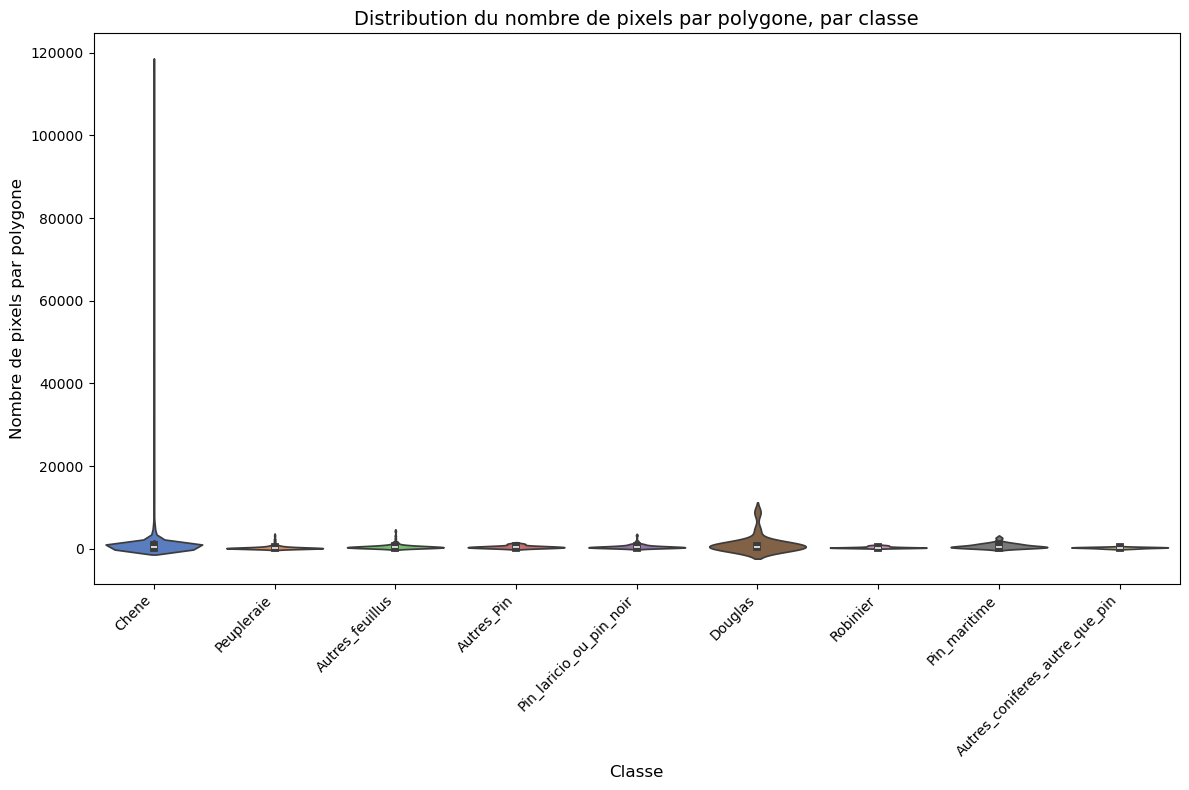

In [11]:
# Création de "violin plot" pour visualiser la distribution du nombre de pixels par polygone, par classe
violin_plot(
    df=df,
    x_col="Classe",
    y_col="Pixels",
    output_file=violin_plot_path, 
    title="Distribution du nombre de pixels par polygone, par classe",
    xlabel="Classe",
    ylabel="Nombre de pixels par polygone",
    palette="muted"
)

In [12]:
df[df['Classe'] == "Douglas"]

,Classe,Catégorie,Pixels
68,Douglas,count,538
143,Douglas,count,293
148,Douglas,count,465
156,Douglas,count,805
158,Douglas,count,403
159,Douglas,count,527
162,Douglas,count,8835
326,Douglas,count,4443
357,Douglas,count,1324
954,Douglas,count,390


/home/onyxia/work/Depot_Git/scripts/my_function.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=x_col, y=y_col, palette=palette)


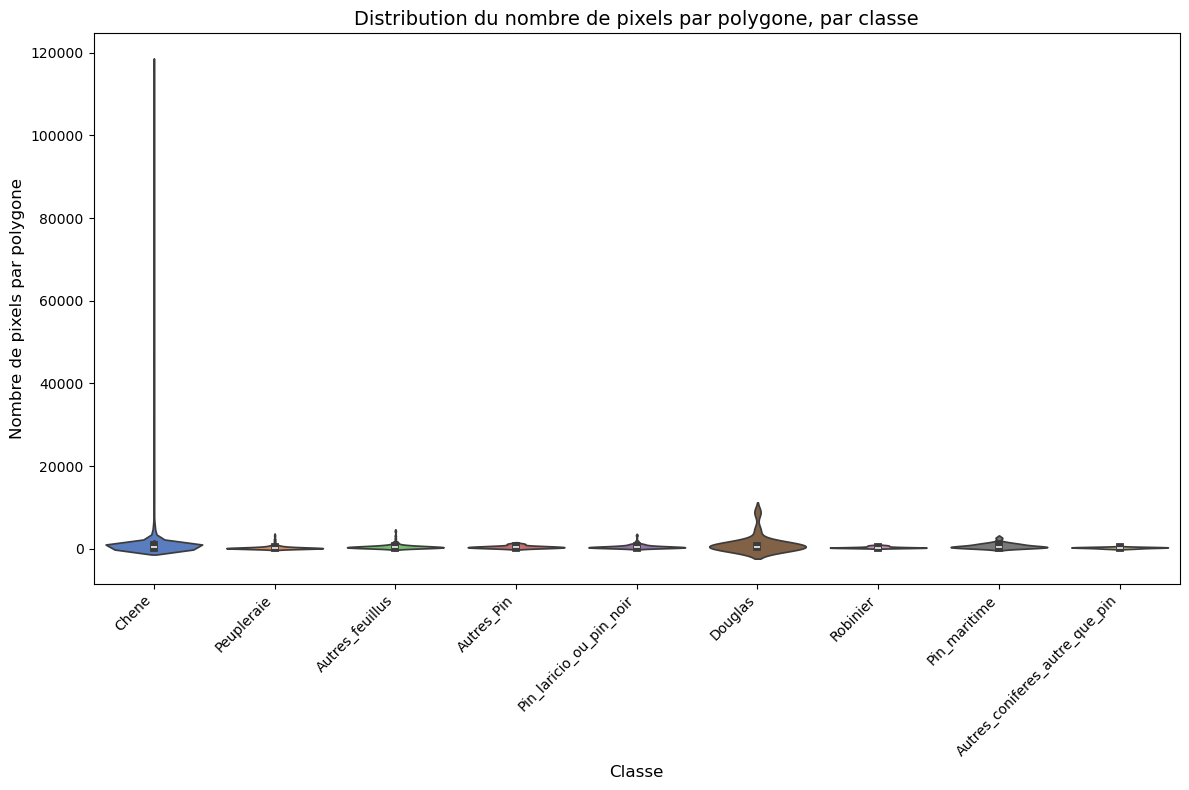

In [14]:
# Création de "violin plot" pour visualiser la distribution du nombre de pixels par polygone, par classe sans tenir compte de la classe dominante "chêne ""
df_filtered = df[df["Classe"] != "Chêne"]
violin_plot(
    df = df_filtered,
    x_col = "Classe",
    y_col ="Pixels",
    output_file = violin_plot_filt_path,
    title ="Distribution du nombre de pixels par polygone, par classe",
    xlabel = "Classe",
    ylabel = "Nombre de pixels par polygone",
    palette = "muted"
)